In [35]:
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, Galactic
from astropy.time import Time
import astropy.units as u
from astroplan import Observer
import numpy as np
import pytz
import datetime

In [36]:
def track_galactic_pst(l_deg, b_deg, year, month, day, latitude_deg, longitude_deg, elevation_m=0):
    # Timezone-aware observer in US/Pacific
    timezone = 'US/Pacific'
    location = EarthLocation(lat=latitude_deg*u.deg, lon=longitude_deg*u.deg, height=elevation_m*u.m)
    observer = Observer(location=location, timezone=timezone)

    # Construct timezone-aware datetime objects at local time
    local_zone = pytz.timezone(timezone)
    base_date = datetime.datetime(year, month, day, tzinfo=local_zone)
    datetimes_local = [base_date.replace(hour=hr) for hr in range(24)]

    # Convert to astropy Time
    times = Time(datetimes_local)

    # Convert galactic to ICRS (RA, Dec)
    galactic = SkyCoord(l=l_deg*u.deg, b=b_deg*u.deg, frame='galactic')
    target_icrs = galactic.transform_to('icrs')

    # Compute AltAz frame for each time
    altaz_frame = AltAz(obstime=times, location=location)
    target_altaz = target_icrs.transform_to(altaz_frame)

    # Output
    print(f"Tracking Galactic coord (l={l_deg}°, b={b_deg}°) on {year}-{month:02d}-{day:02d} PST/PDT")
    print(f"{'Local Hour':>10} | {'Altitude (deg)':>14} | {'Azimuth (deg)':>13}")
    print("-" * 42)
    for dt, alt, az in zip(datetimes_local, target_altaz.alt, target_altaz.az):
        hour_label = dt.strftime("%H:%M")
        print(f"{hour_label:>10} | {alt:.6} | {az:.6}")


In [37]:
def track_multiple_galactic_pst(l_array, b_array, year, month, day, latitude_deg, longitude_deg, elevation_m=0):
    from astropy.coordinates import EarthLocation, AltAz, SkyCoord
    from astropy.time import Time
    from astropy.coordinates import Angle
    import astropy.units as u
    import pytz
    import datetime
    from astroplan import Observer

    assert len(l_array) == len(b_array), "l_array and b_array must be the same length."

    timezone = 'US/Pacific'
    location = EarthLocation(lat=latitude_deg*u.deg, lon=longitude_deg*u.deg, height=elevation_m*u.m)
    observer = Observer(location=location, timezone=timezone)

    local_zone = pytz.timezone(timezone)
    base_date = datetime.datetime(year, month, day, tzinfo=local_zone)
    datetimes_local = [base_date.replace(hour=hr) for hr in range(24)]
    times = Time(datetimes_local)

    results = []

    for l_deg, b_deg in zip(l_array, b_array):
        galactic = SkyCoord(l=l_deg*u.deg, b=b_deg*u.deg, frame='galactic')
        target_icrs = galactic.transform_to('icrs')
        altaz_frame = AltAz(obstime=times, location=location)
        target_altaz = target_icrs.transform_to(altaz_frame)

        coord_results = {
            'l': l_deg,
            'b': b_deg,
            'altitudes': target_altaz.alt.deg,
            'azimuths': target_altaz.az.deg,
            'hours': [dt.strftime("%H:%M") for dt in datetimes_local]
        }

        results.append(coord_results)

    return results


In [38]:
def hourly_visibility_percentage(l_array, b_array, year, month, day, latitude_deg, longitude_deg, elevation_m=0):
    from astropy.coordinates import EarthLocation, AltAz, SkyCoord
    from astropy.time import Time
    import astropy.units as u
    import pytz
    import datetime
    from astroplan import Observer
    import numpy as np
    import pandas as pd

    assert len(l_array) == len(b_array), "l_array and b_array must be the same length."
    n_points = len(l_array)

    timezone = 'US/Pacific'
    location = EarthLocation(lat=latitude_deg*u.deg, lon=longitude_deg*u.deg, height=elevation_m*u.m)
    observer = Observer(location=location, timezone=timezone)

    local_zone = pytz.timezone(timezone)
    base_date = datetime.datetime(year, month, day, tzinfo=local_zone)
    datetimes_local = [base_date.replace(hour=hr) for hr in range(24)]
    times = Time(datetimes_local)

    # Store results
    results = []

    for time, dt_local in zip(times, datetimes_local):
        visible_count = 0
        for l_deg, b_deg in zip(l_array, b_array):
            galactic = SkyCoord(l=l_deg*u.deg, b=b_deg*u.deg, frame='galactic')
            target_icrs = galactic.transform_to('icrs')
            altaz = target_icrs.transform_to(AltAz(obstime=time, location=location))

            az = altaz.az.deg
            alt = altaz.alt.deg

            # Visibility conditions
            az_condition = not (az >= 355 or az <= 5)
            alt_condition = 14 < alt < 85

            if az_condition and alt_condition:
                visible_count += 1

        visibility_percent = 100.0 * visible_count / n_points
        results.append({
            'Hour': dt_local.strftime('%H:%M'),
            'Visible %': round(visibility_percent, 1)
        })

    return pd.DataFrame(results)


In [39]:
track_multiple_galactic_pst(l_array, b_array, year, month, day, latitude_deg, longitude_deg, elevation_m=0)

NameError: name 'l_array' is not defined

In [29]:
l = coord_array[:,0] 
b = coord_array[:,1]

In [33]:
len(l)

309

In [31]:

# Example usage
hourly_visibility_percentage(
    l_array=l,         # Galactic longitude
     b_array=b,          # Galactic latitude
    year=2025,
    month=4,
    day=26,
    latitude_deg=37.87, # e.g., Berkeley, CA
    longitude_deg=-122.27,
    elevation_m=580
)


,Hour,Visible %
0,00:00,84.5
1,01:00,82.5
2,02:00,78.0
3,03:00,73.1
4,04:00,67.0
5,05:00,64.7
6,06:00,60.5
7,07:00,60.5
8,08:00,65.4
9,09:00,70.2


In [12]:

# Example usage
track_galactic_pst(
    l_deg=[1],         # Galactic longitude
    b_deg=[0,1],          # Galactic latitude
    year=2025,
    month=4,
    day=18,
    latitude_deg=37.87, # e.g., Berkeley, CA
    longitude_deg=-122.27
)


NameError: name 'track_galactic_pst' is not defined

In [47]:

# Example usage
track_galactic_pst(
    l_deg=120,         # Galactic longitude
    b_deg=0,          # Galactic latitude
    year=2025,
    month=4,
    day=26,
    latitude_deg=37.87, # e.g., Berkeley, CA
    longitude_deg=-122.27
)


Tracking Galactic coord (l=120°, b=0°) on 2025-04-26 PST/PDT
Local Hour | Altitude (deg) | Azimuth (deg)
------------------------------------------
     00:00 | 12.5183 deg | 10.8513 deg
     01:00 | 15.408 deg | 17.2464 deg
     02:00 | 19.5031 deg | 22.9978 deg
     03:00 | 24.6189 deg | 27.9075 deg
     04:00 | 30.5434 deg | 31.7787 deg
     05:00 | 37.0429 deg | 34.3656 deg
     06:00 | 43.8514 deg | 35.2953 deg
     07:00 | 50.6357 deg | 33.9528 deg
     08:00 | 56.9217 deg | 29.3518 deg
     09:00 | 61.9747 deg | 20.2323 deg
     10:00 | 64.7561 deg | 6.23536 deg
     11:00 | 64.3848 deg | 350.276 deg
     12:00 | 60.9954 deg | 337.268 deg
     13:00 | 55.5835 deg | 329.264 deg
     14:00 | 49.1326 deg | 325.503 deg
     15:00 | 42.3081 deg | 324.743 deg
     16:00 | 35.5434 deg | 326.088 deg
     17:00 | 29.1515 deg | 328.991 deg
     18:00 | 23.3894 deg | 333.114 deg
     19:00 | 18.4855 deg | 338.23 deg
     20:00 | 14.6468 deg | 344.144 deg
     21:00 | 12.0497 deg | 350.654 

In [13]:

# Example usage
track_galactic_pst(
    l_deg=105.0,         # Galactic longitude
    b_deg=50.0,          # Galactic latitude
    year=2025,
    month=4,
    day=17,
    latitude_deg=37.87, # e.g., Berkeley, CA
    longitude_deg=-122.27
)


Tracking Galactic coord (l=105.0°, b=50.0°) on 2025-04-17 PST/PDT
Local Hour | Altitude (deg) | Azimuth (deg)
------------------------------------------
     00:00 | 62.5336 deg | 17.0869 deg
     01:00 | 64.6114 deg | 2.58557 deg
     02:00 | 63.5349 deg | 347.276 deg
     03:00 | 59.678 deg | 335.553 deg
     04:00 | 54.0568 deg | 328.649 deg
     05:00 | 47.5676 deg | 325.627 deg
     06:00 | 40.8079 deg | 325.349 deg
     07:00 | 34.1766 deg | 327.023 deg
     08:00 | 27.971 deg | 330.164 deg
     09:00 | 22.44 deg | 334.468 deg
     10:00 | 17.8064 deg | 339.716 deg
     11:00 | 14.2694 deg | 345.715 deg
     12:00 | 11.9949 deg | 352.256 deg
     13:00 | 11.0973 deg | 359.097 deg
     14:00 | 11.6239 deg | 5.97411 deg
     15:00 | 13.547 deg | 12.6177 deg
     16:00 | 16.768 deg | 18.7796 deg
     17:00 | 21.1329 deg | 24.2429 deg
     18:00 | 26.4499 deg | 28.8128 deg
     19:00 | 32.5018 deg | 32.2827 deg
     20:00 | 39.0478 deg | 34.3783 deg
     21:00 | 45.807 deg | 34.6722 

In [67]:

# Example usage
track_galactic_pst(
    l_deg=160.0,         # Galactic longitude
    b_deg=15.0,          # Galactic latitude
    year=2025,
    month=4,
    day=17,
    latitude_deg=37.87, # e.g., Berkeley, CA
    longitude_deg=-122.27
)


Tracking Galactic coord (l=160.0°, b=15.0°) on 2025-04-17 PST/PDT
Local Hour | Altitude (deg) | Azimuth (deg)
------------------------------------------
     00:00 | 19.4215 deg | 323.681 deg
     01:00 | 12.9206 deg | 330.057 deg
     02:00 | 7.65362 deg | 337.386 deg
     03:00 | 3.86801 deg | 345.514 deg
     04:00 | 1.77232 deg | 354.203 deg
     05:00 | 1.49534 deg | 3.13031 deg
     06:00 | 3.05489 deg | 11.9279 deg
     07:00 | 6.35309 deg | 20.2533 deg
     08:00 | 11.2011 deg | 27.8414 deg
     09:00 | 17.359 deg | 34.5155 deg
     10:00 | 24.572 deg | 40.1549 deg
     11:00 | 32.5911 deg | 44.6307 deg
     12:00 | 41.1744 deg | 47.7088 deg
     13:00 | 50.065 deg | 48.8758 deg
     14:00 | 58.9226 deg | 46.9409 deg
     15:00 | 67.1171 deg | 39.0407 deg
     16:00 | 73.1015 deg | 19.2662 deg
     17:00 | 73.8625 deg | 347.602 deg
     18:00 | 68.8075 deg | 324.257 deg
     19:00 | 60.9358 deg | 314.211 deg
     20:00 | 52.158 deg | 311.232 deg
     21:00 | 43.239 deg | 311.81

In [69]:

# Example usage
track_galactic_pst(
    l_deg=160.0,         # Galactic longitude
    b_deg=50.0,          # Galactic latitude
    year=2025,
    month=4,
    day=18,
    latitude_deg=37.87, # e.g., Berkeley, CA
    longitude_deg=-122.27
)


Tracking Galactic coord (l=160.0°, b=50.0°) on 2025-04-18 PST/PDT
Local Hour | Altitude (deg) | Azimuth (deg)
------------------------------------------
     00:00 | 52.5313 deg | 311.356 deg
     01:00 | 43.6199 deg | 311.816 deg
     02:00 | 34.9336 deg | 314.425 deg
     03:00 | 26.7428 deg | 318.537 deg
     04:00 | 19.2902 deg | 323.862 deg
     05:00 | 12.822 deg | 330.253 deg
     06:00 | 7.5926 deg | 337.594 deg
     07:00 | 3.8486 deg | 345.729 deg
     08:00 | 1.79669 deg | 354.417 deg
     09:00 | 1.5631 deg | 3.3344 deg
     10:00 | 3.16283 deg | 12.1141 deg
     11:00 | 6.49573 deg | 20.4152 deg
     12:00 | 11.3717 deg | 27.9747 deg
     13:00 | 17.5505 deg | 34.6179 deg
     14:00 | 24.7777 deg | 40.2238 deg
     15:00 | 32.8045 deg | 44.6615 deg
     16:00 | 41.389 deg | 47.6921 deg
     17:00 | 50.273 deg | 48.7909 deg
     18:00 | 59.1118 deg | 46.7423 deg
     19:00 | 67.2618 deg | 38.6307 deg
     20:00 | 73.144 deg | 18.5403 deg
     21:00 | 73.7514 deg | 346.942 d

In [4]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

# Define galactic latitude range and spacing
b_vals = np.linspace(15, 50, int((50 - 15) / 2.4) + 1)  # inclusive
coord_list = []

for b in b_vals:
    cosb = np.cos(np.deg2rad(b))
    dell = 2.4 / cosb
    l_vals = np.linspace(105, 160, int((160 - 105) / dell) + 1)
    for l in l_vals:
        coord = SkyCoord(l=l*u.deg, b=b*u.deg, frame='galactic')
        coord_list.append(coord)

# Optional: Convert to RA/Dec
radec_list = [coord.transform_to('icrs') for coord in coord_list]

# Output example: matrix of (l, b)
coord_matrix = np.array([(c.l.deg, c.b.deg) for c in coord_list])
coord_matrix

array([[105.        ,  15.        ],
       [107.5       ,  15.        ],
       [110.        ,  15.        ],
       [112.5       ,  15.        ],
       [115.        ,  15.        ],
       [117.5       ,  15.        ],
       [120.        ,  15.        ],
       [122.5       ,  15.        ],
       [125.        ,  15.        ],
       [127.5       ,  15.        ],
       [130.        ,  15.        ],
       [132.5       ,  15.        ],
       [135.        ,  15.        ],
       [137.5       ,  15.        ],
       [140.        ,  15.        ],
       [142.5       ,  15.        ],
       [145.        ,  15.        ],
       [147.5       ,  15.        ],
       [150.        ,  15.        ],
       [152.5       ,  15.        ],
       [155.        ,  15.        ],
       [157.5       ,  15.        ],
       [160.        ,  15.        ],
       [105.        ,  17.5       ],
       [107.61904762,  17.5       ],
       [110.23809524,  17.5       ],
       [112.85714286,  17.5       ],
 

In [6]:
import numpy as np

# Define b range and spacing
b_vals = np.arange(15, 50, 2.4)

# Append 50 if it's not already included (within numerical tolerance)
if not np.isclose(b_vals[-1], 50):
    b_vals = np.append(b_vals, 50)

# Prepare list to hold (l, b) pairs
coords = []

for b in b_vals:
    # Convert b to radians for cosine
    b_rad = np.radians(b)
    # Longitude spacing
    delta_l = 2.4 / np.cos(b_rad)
    # Define l range for this b
    l_vals = np.arange(105, 160 + 1e-6, delta_l)
    for l in l_vals:
        coords.append((round(l, 4), round(b, 4)))  # Rounded for neatness

# Convert to numpy array for matrix-style handling
coord_array = np.array(coords)

# Print or return
for l, b in coord_array:
    print(f"l: {l:.4f}, b: {b:.4f}")


l: 105.0000, b: 15.0000
l: 107.4847, b: 15.0000
l: 109.9693, b: 15.0000
l: 112.4540, b: 15.0000
l: 114.9387, b: 15.0000
l: 117.4233, b: 15.0000
l: 119.9080, b: 15.0000
l: 122.3926, b: 15.0000
l: 124.8773, b: 15.0000
l: 127.3620, b: 15.0000
l: 129.8466, b: 15.0000
l: 132.3313, b: 15.0000
l: 134.8160, b: 15.0000
l: 137.3006, b: 15.0000
l: 139.7853, b: 15.0000
l: 142.2699, b: 15.0000
l: 144.7546, b: 15.0000
l: 147.2393, b: 15.0000
l: 149.7239, b: 15.0000
l: 152.2086, b: 15.0000
l: 154.6933, b: 15.0000
l: 157.1779, b: 15.0000
l: 159.6626, b: 15.0000
l: 105.0000, b: 17.4000
l: 107.5151, b: 17.4000
l: 110.0302, b: 17.4000
l: 112.5453, b: 17.4000
l: 115.0604, b: 17.4000
l: 117.5754, b: 17.4000
l: 120.0905, b: 17.4000
l: 122.6056, b: 17.4000
l: 125.1207, b: 17.4000
l: 127.6358, b: 17.4000
l: 130.1509, b: 17.4000
l: 132.6660, b: 17.4000
l: 135.1811, b: 17.4000
l: 137.6962, b: 17.4000
l: 140.2113, b: 17.4000
l: 142.7263, b: 17.4000
l: 145.2414, b: 17.4000
l: 147.7565, b: 17.4000
l: 150.2716, b: 

In [68]:
coord_array.shape

(309, 2)

In [66]:
coord_array

array([[105.    ,  15.    ],
       [107.4847,  15.    ],
       [109.9693,  15.    ],
       [112.454 ,  15.    ],
       [114.9387,  15.    ],
       [117.4233,  15.    ],
       [119.908 ,  15.    ],
       [122.3926,  15.    ],
       [124.8773,  15.    ],
       [127.362 ,  15.    ],
       [129.8466,  15.    ],
       [132.3313,  15.    ],
       [134.816 ,  15.    ],
       [137.3006,  15.    ],
       [139.7853,  15.    ],
       [142.2699,  15.    ],
       [144.7546,  15.    ],
       [147.2393,  15.    ],
       [149.7239,  15.    ],
       [152.2086,  15.    ],
       [154.6933,  15.    ],
       [157.1779,  15.    ],
       [159.6626,  15.    ],
       [105.    ,  17.4   ],
       [107.5151,  17.4   ],
       [110.0302,  17.4   ],
       [112.5453,  17.4   ],
       [115.0604,  17.4   ],
       [117.5754,  17.4   ],
       [120.0905,  17.4   ],
       [122.6056,  17.4   ],
       [125.1207,  17.4   ],
       [127.6358,  17.4   ],
       [130.1509,  17.4   ],
       [132.66

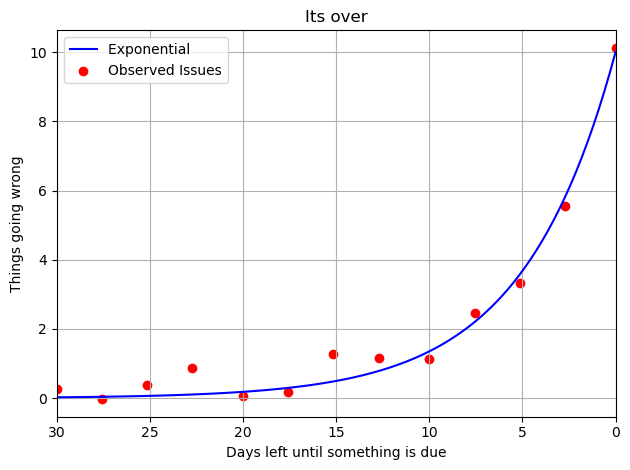

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate x-values: days left until due (from 30 to 0)
days_left = np.linspace(30, 0, 100)

# Define an exponential function for the trend
# As days decrease, things going wrong increase exponentially
# We'll model this as an exponential decay from 30 to 0 days,
# then invert it to represent increasing issues
base_trend = np.exp((30 - days_left) / 5)

# Normalize the trend to a reasonable scale
base_trend = base_trend / np.max(base_trend) * 10

# Generate 13 discrete data points with some noise
num_points = 13
sample_indices = np.linspace(0, len(days_left) - 1, num_points, dtype=int)
sample_days = days_left[sample_indices]
sample_issues = base_trend[sample_indices] + np.random.normal(0, 0.5, num_points)

# Plot the exponential trend line
plt.plot(days_left, base_trend, label='Exponential ', color='blue')

# Plot the discrete data points
plt.scatter(sample_days, sample_issues, color='red', label='Observed Issues')

# Customize the plot
plt.xlabel('Days left until something is due')
plt.ylabel('Things going wrong')
plt.title('Its over')
plt.xlim(30, 0)  # Reverse x-axis: 30 to 0
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()
